In [ ]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
import time
import cv2 as cv
import os
import glob 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/My Drive/Machine Intelligence 3rd Year Intro to MI Data/Assignment4/My images"

Mounted at /content/drive


# 2. Input Dataset

In [ ]:
# calculate mean and std 
def get_normalize_parameters():
  image_path = glob.glob("/content/*.JPG")
  chan0,chan1,chan2 = [],[],[]

  mean = []
  std = []
  count = 0
  
  for img in image_path:
    n = cv.imread(img)
    chan0.append(np.array(n[0]/255))
    chan1.append(np.array(n[1]/255))
    chan2.append(np.array(n[2]/255))

  mean = [np.average(np.array(chan0).flatten()),
          np.average(np.array(chan1).flatten()),
          np.average(np.array(chan2).flatten())]

  std = [np.std(np.array(chan0).flatten()),
          np.std(np.array(chan1).flatten()),
          np.std(np.array(chan2).flatten())]
  return mean,std


In [ ]:
# storing mean and std for personal images

mean = [0.7588266417678181, 0.7589589169000933, 0.7571638655462185]
std = [0.0596196770247298, 0.06274349303641723, 0.07081604841737071]

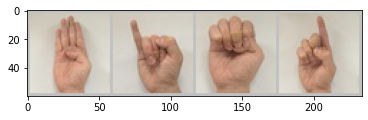

In [ ]:
def get_data(batch_size,mean,std,path):
  # define transform 
  transform = transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize(mean,std)])

  # load the images from the path in drive with defined transformations 
  dataset = torchvision.datasets.ImageFolder(root=path,transform=transform)

  # define dataloader 
  dataloader = torch.utils.data.DataLoader(dataset,batch_size = batch_size,shuffle=True)
  return dataloader

def imshow(img,mean,std):
  for i in range(len(img)):
    img[i] = img[i] * std[i] + mean[i]
  plt.imshow(np.transpose(img,(1,2,0)))
  plt.show()

dataloader = get_data(4,mean,std,path)
images,labels  = iter(dataloader).next()
imshow(torchvision.utils.make_grid(images),mean,std)

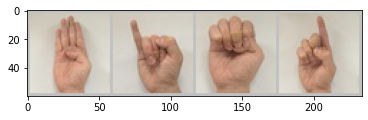

    B           I           E           D


In [ ]:
# showing 4 images and their corresponding labels
classes = ('A','B','C','D','E','F','G','H','I','K')
imshow(torchvision.utils.make_grid(images),mean,std)
print('       '.join('%5s' % classes[labels[j]] for j in range(4)))

# 3. Model Building and Testing

In [ ]:
# defining the model
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    self.conv1 = nn.Conv2d(3,4,3)
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(4,8,5)
    self.fc1 = nn.Linear(8*11*11,100)
    self.fc2 = nn.Linear(100,64)
    self.fc3 = nn.Linear(64,10)

  def forward(self,x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1,8*11*11)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)

    return x

def TenToOneH(argument):
  switcher = {
    0: [1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
    1: [0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
    2: [0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
    3: [0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0],
    4: [0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0],
    5: [0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0],
    6: [0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0],
    7: [0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0],
    8: [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0],
    9: [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0]}
  return (switcher[argument])

def load_model(lr):
  model = Net()
  loss_fcn = nn.MSELoss()
  optimizer = torch.optim.SGD(model.parameters(),lr=lr)
  return model, loss_fcn, optimizer


In [ ]:
batch_size = 10 
lr = 0.01
epochs = 100
seed = 0

In [ ]:

torch.manual_seed(seed)
def train(batch_size,lr,epochs):
  train_loader = get_data(batch_size,mean,std,path)
  model,loss_fcn,optimizer = load_model(lr)


  trainAccRec = []
  loss_rec = []
  t = []
  tic = time.time()


  model.train()
  for epoch in range (1,epochs+1):
    correct = 0
    total = 0
    for i,(inputs,labels) in enumerate(train_loader,0):
      labels_H = torch.tensor([TenToOneH(float(i)) for i in labels])

  
      optimizer.zero_grad()   
      predict = model(inputs.float())
      
      loss = loss_fcn(input = predict.squeeze(),target=labels_H.float())
      loss.backward()
      optimizer.step()
      

      _, predicted = torch.max(predict.data,1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
    
    train_acc = correct / total
    trainAccRec.append(train_acc)
    t.append(time.time()-tic)
    loss_rec.append(loss.item())  

    print("Epoch = %d"%epoch)
    print("Training accuracy: %.3f"%train_acc)
    print("Loss: %.3f"%loss.item())
    print("\n")



  toc = time.time()
  print("Total time:%.3f"%(toc-tic))
  num_epochs = list(range(epochs)) 


  plt.plot(num_epochs,trainAccRec,label="Training Accuracy")
  plt.legend()
  plt.xlabel("Number of Epochs")
  plt.ylabel("Training Accuracy")
  plt.title("Number of Epochs Vs Training Accuracy")
  plt.show()

  plt.plot(num_epochs,loss_rec,label="Loss")
  plt.xlabel("Number of Epochs")
  plt.ylabel("Loss")
  plt.title("Number of Epochs Vs. Loss")
  plt.legend()
  plt.show()



  plt.plot(t,trainAccRec,label="Training Accuracy")
  plt.xlabel("Time[s]")
  plt.ylabel("Training Accuracy")
  plt.title("Time Vs. Training Accuracy")
  plt.legend()
  plt.show()
  return model


Epoch = 1
Training accuracy: 0.200
Loss: 0.107


Epoch = 2
Training accuracy: 0.200
Loss: 0.103


Epoch = 3
Training accuracy: 0.200
Loss: 0.102


Epoch = 4
Training accuracy: 0.200
Loss: 0.099


Epoch = 5
Training accuracy: 0.200
Loss: 0.099


Epoch = 6
Training accuracy: 0.200
Loss: 0.105


Epoch = 7
Training accuracy: 0.200
Loss: 0.101


Epoch = 8
Training accuracy: 0.200
Loss: 0.093


Epoch = 9
Training accuracy: 0.200
Loss: 0.095


Epoch = 10
Training accuracy: 0.200
Loss: 0.089


Epoch = 11
Training accuracy: 0.200
Loss: 0.102


Epoch = 12
Training accuracy: 0.200
Loss: 0.087


Epoch = 13
Training accuracy: 0.200
Loss: 0.096


Epoch = 14
Training accuracy: 0.200
Loss: 0.087


Epoch = 15
Training accuracy: 0.200
Loss: 0.092


Epoch = 16
Training accuracy: 0.200
Loss: 0.085


Epoch = 17
Training accuracy: 0.200
Loss: 0.089


Epoch = 18
Training accuracy: 0.200
Loss: 0.085


Epoch = 19
Training accuracy: 0.200
Loss: 0.085


Epoch = 20
Training accuracy: 0.200
Loss: 0.089


Epoch = 2

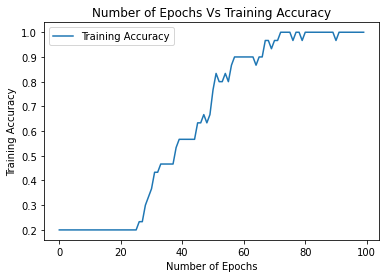

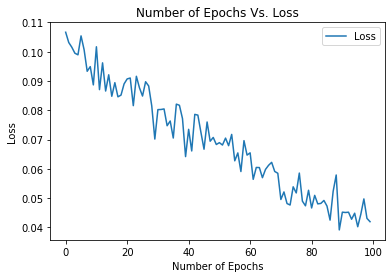

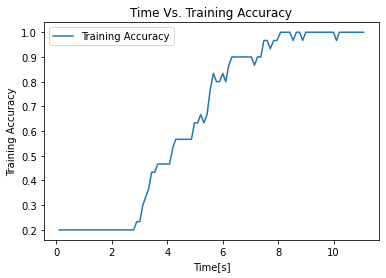

In [ ]:
model = train(batch_size,lr,epochs)

In [ ]:
summary(model,(3,56,56))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 54, 54]             112
         MaxPool2d-2            [-1, 4, 27, 27]               0
            Conv2d-3            [-1, 8, 23, 23]             808
         MaxPool2d-4            [-1, 8, 11, 11]               0
            Linear-5                  [-1, 100]          96,900
            Linear-6                   [-1, 64]           6,464
            Linear-7                   [-1, 10]             650
Total params: 104,934
Trainable params: 104,934
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.04
Forward/backward pass size (MB): 0.15
Params size (MB): 0.40
Estimated Total Size (MB): 0.59
----------------------------------------------------------------


# 4. Using the Full Data Set

## 4.1 Data Loading and Splitting

In [ ]:
new_path = "/content/drive/My Drive/Machine Intelligence 3rd Year Intro to MI Data/Assignment4/Full dataset"
def get_full_normalize_paramters():
  letters = ['A','B','C','D','E','F','G','H','I','K']
  for letter in letters:
    image_path = glob.glob(new_path+'/'+letter+"/*.jpg")
    chan0,chan1,chan2 = [],[],[]
    mean = []
    std = []

    
    for img in image_path:
      n = cv.imread(img)
      chan0.append(np.array(n[0]/255))
      chan1.append(np.array(n[1]/255))
      chan2.append(np.array(n[2]/255))
     
    print(letter+" done!\n")

  mean = [np.average(np.array(chan0).flatten()),
            np.average(np.array(chan1).flatten()),
            np.average(np.array(chan2).flatten())]

  std = [np.std(np.array(chan0).flatten()),
            np.std(np.array(chan1).flatten()),
            np.std(np.array(chan2).flatten())]
      
    
  return mean,std


In [ ]:
# storing the mean and std for the whole dataset into a separate variable 
# new_mean,new_std = get_full_normalize_paramters()

new_mean = [0.7458459809779424, 0.7445457143567186, 0.7422643455354258]
new_std = [0.11261820096134469, 0.11160372862894079, 0.1122811851077723]

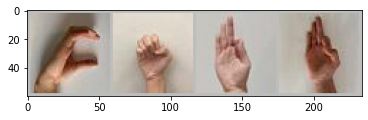

    C           E           F           F


In [ ]:
# checking for ground truth 
dataloader = get_data(4,new_mean,new_std,new_path)
images,labels  = iter(dataloader).next()
classes = ('A','B','C','D','E','F','G','H','I','K')
imshow(torchvision.utils.make_grid(images),new_mean,new_std)
print('       '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
def get_split_data(batch_size,mean,std,path,val_split):
  # define transform 
  transform = transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize(mean,std)])

  # load the images from the path in drive with defined transformations 
  dataset = torchvision.datasets.ImageFolder(root=path,transform=transform)
  
  # define dataloader 
  dataloader = torch.utils.data.DataLoader(dataset)
  train_idx, val_idx = train_test_split(list(range(len(dataloader))), test_size=val_split)
  
  train_ds = Subset(dataset, train_idx)
  valid_ds = Subset(dataset, val_idx)

  train_loader = torch.utils.data.DataLoader(dataset = train_ds,batch_size = batch_size,shuffle=True)
  valid_loader = torch.utils.data.DataLoader(dataset = valid_ds,batch_size = batch_size)
  return train_loader,valid_loader



## 4.3 Hyperparamter Search

In [ ]:
def evaluate(model,val_loader):
  total = 0 
  correct = 0
  for idx,(inputs,labels) in enumerate(val_loader,0):
    predict = model(inputs.float())
    _, predicted = torch.max(predict.data,1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
  val_acc = correct / total

  return val_acc

def train_full(batch_size,lr,epochs,model):
 
  train_loader,val_loader = get_split_data(batch_size,new_mean,new_std,new_path,0.2)
  loss_fcn = nn.MSELoss()
  optimizer = torch.optim.SGD(model.parameters(),lr=lr)

  trainAccRec = []
  valAccRec = []
  loss_rec = []
  t = []
  tic = time.time()


  model.train()
  for epoch in range (1,epochs+1):
    correct = 0
    total = 0
    for i,(inputs,labels) in enumerate(train_loader,0):
      
      labels_H = torch.tensor([TenToOneH(float(i)) for i in labels])
      optimizer.zero_grad()   
      predict = model(inputs.float())

      
      
      loss = loss_fcn(input = predict.squeeze(),target=labels_H.float())
      loss.backward()
      optimizer.step()
      

      _, predicted = torch.max(predict.data,1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      
  
    train_acc = correct / total
    val_acc = evaluate(model,val_loader)

    valAccRec.append(val_acc)
    trainAccRec.append(train_acc)

    t.append(time.time()-tic)
    loss_rec.append(loss.item())  

    print("Epoch = %d"%epoch)
    print("Training accuracy: %.3f"%train_acc)
    print("Validation accuracy: %.3f"%val_acc)
    print("Loss: %.3f"%loss.item())
    print("Time: %.2f"%(time.time()-tic))
    print("\n")

  toc = time.time()
  print("Total time:%.3f"%(toc-tic))
  num_epochs = list(range(epochs)) 

  plt.plot(num_epochs,trainAccRec,label="Training Accuracy")
  plt.plot(num_epochs,valAccRec,label="Validation Accuracy")
  plt.legend()
  plt.xlabel("Number of Epochs")
  plt.ylabel("Training/Validation Accuracy")
  plt.title("Number of Epochs Vs Training/Validation Accuracy")
  plt.show()

  plt.plot(num_epochs,loss_rec,label="Loss")
  plt.xlabel("Number of Epochs")
  plt.ylabel("Loss")
  plt.title("Number of Epochs Vs. Loss")
  plt.legend()
  plt.show()
  
  return model

### Run 1 Paramaters:
##### *Number of Conv. layers: 2*
##### *Number of kernels on each conv. layer: 10*
##### *Number of Neurons on first layer: 32*
##### *Learning rate: 0.1*
##### *Batch size: 4*
##### *Epochs: 30*


In [ ]:
# Model 1
class Net1(nn.Module):
  def __init__(self):
    super(Net1,self).__init__()
    self.conv1 = nn.Conv2d(3,10,3)
    self.pool1 = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(10,10,3)
    self.pool2 = nn.MaxPool2d(2,2,padding = 1)

    self.fc1 = nn.Linear(13*13*10,32)
    self.fc2 = nn.Linear(32,16)
    self.fc3 = nn.Linear(16,10)

  def forward(self,x):
    x = self.pool1(F.relu(self.conv1(x)))
    x = self.pool2(F.relu(self.conv2(x)))
    x = x.view(-1,13*13*10)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = (self.fc3(x))
    return x
summary(Net1(),(3,56,56))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 54, 54]             280
         MaxPool2d-2           [-1, 10, 27, 27]               0
            Conv2d-3           [-1, 10, 25, 25]             910
         MaxPool2d-4           [-1, 10, 13, 13]               0
            Linear-5                   [-1, 32]          54,112
            Linear-6                   [-1, 16]             528
            Linear-7                   [-1, 10]             170
Total params: 56,000
Trainable params: 56,000
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.04
Forward/backward pass size (MB): 0.34
Params size (MB): 0.21
Estimated Total Size (MB): 0.59
----------------------------------------------------------------


Epoch = 1
Training accuracy: 0.382
Validation accuracy: 0.552
Loss: 0.080
Time: 12.34


Epoch = 2
Training accuracy: 0.609
Validation accuracy: 0.671
Loss: 0.067
Time: 24.63


Epoch = 3
Training accuracy: 0.701
Validation accuracy: 0.715
Loss: 0.060
Time: 36.93


Epoch = 4
Training accuracy: 0.770
Validation accuracy: 0.738
Loss: 0.006
Time: 49.35


Epoch = 5
Training accuracy: 0.811
Validation accuracy: 0.789
Loss: 0.003
Time: 62.32


Epoch = 6
Training accuracy: 0.844
Validation accuracy: 0.747
Loss: 0.074
Time: 75.75


Epoch = 7
Training accuracy: 0.862
Validation accuracy: 0.783
Loss: 0.084
Time: 87.98


Epoch = 8
Training accuracy: 0.884
Validation accuracy: 0.781
Loss: 0.005
Time: 100.43


Epoch = 9
Training accuracy: 0.894
Validation accuracy: 0.793
Loss: 0.062
Time: 112.91


Epoch = 10
Training accuracy: 0.915
Validation accuracy: 0.830
Loss: 0.006
Time: 125.71


Epoch = 11
Training accuracy: 0.922
Validation accuracy: 0.840
Loss: 0.003
Time: 138.21


Epoch = 12
Training accura

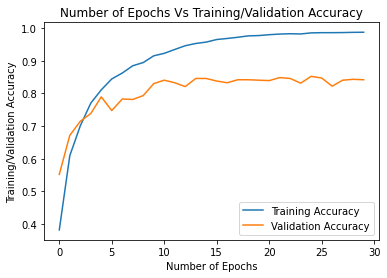

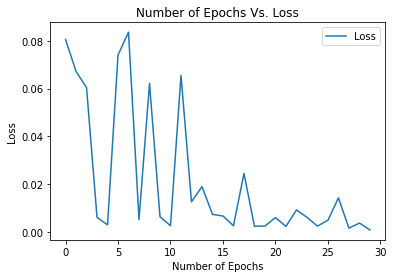

done


In [ ]:
batch_size = 4 
lr = 0.1
epochs = 30
seed = 0
model = train_full(batch_size,lr,epochs,Net1())
print("done")

### **Run 2 Paramaters:**
##### *Number of Conv. layers: 2*
##### *Number of kernels on each conv. layer: 10*
##### *Number of Neurons on first layer: 8*
##### *Learning rate: 0.1*
##### *Batch size: 4*
##### *Epochs: 30*

In [ ]:
# Model 2
class Net2(nn.Module):
  def __init__(self):
    super(Net2,self).__init__()
    self.conv1 = nn.Conv2d(3,10,3)
    self.pool1 = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(10,10,3)
    self.pool2 = nn.MaxPool2d(2,2,padding = 1)

    self.fc1 = nn.Linear(13*13*10,8)
    self.fc2 = nn.Linear(8,4)
    self.fc3 = nn.Linear(4,10)

  def forward(self,x):
    x = self.pool1(F.relu(self.conv1(x)))
    x = self.pool2(F.relu(self.conv2(x)))
    x = x.view(-1,13*13*10)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = (self.fc3(x))
    return x
summary(Net2(),(3,56,56))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 54, 54]             280
         MaxPool2d-2           [-1, 10, 27, 27]               0
            Conv2d-3           [-1, 10, 25, 25]             910
         MaxPool2d-4           [-1, 10, 13, 13]               0
            Linear-5                    [-1, 8]          13,528
            Linear-6                    [-1, 4]              36
            Linear-7                   [-1, 10]              50
Total params: 14,804
Trainable params: 14,804
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.04
Forward/backward pass size (MB): 0.34
Params size (MB): 0.06
Estimated Total Size (MB): 0.43
----------------------------------------------------------------


Epoch = 1
Training accuracy: 0.150
Validation accuracy: 0.253
Loss: 0.082
Time: 12.15


Epoch = 2
Training accuracy: 0.277
Validation accuracy: 0.301
Loss: 0.086
Time: 23.92


Epoch = 3
Training accuracy: 0.347
Validation accuracy: 0.348
Loss: 0.070
Time: 36.10


Epoch = 4
Training accuracy: 0.381
Validation accuracy: 0.361
Loss: 0.076
Time: 48.35


Epoch = 5
Training accuracy: 0.390
Validation accuracy: 0.348
Loss: 0.056
Time: 60.55


Epoch = 6
Training accuracy: 0.424
Validation accuracy: 0.363
Loss: 0.046
Time: 72.92


Epoch = 7
Training accuracy: 0.415
Validation accuracy: 0.404
Loss: 0.068
Time: 85.17


Epoch = 8
Training accuracy: 0.417
Validation accuracy: 0.429
Loss: 0.040
Time: 97.33


Epoch = 9
Training accuracy: 0.413
Validation accuracy: 0.423
Loss: 0.045
Time: 109.42


Epoch = 10
Training accuracy: 0.426
Validation accuracy: 0.360
Loss: 0.088
Time: 122.36


Epoch = 11
Training accuracy: 0.421
Validation accuracy: 0.366
Loss: 0.077
Time: 135.61


Epoch = 12
Training accurac

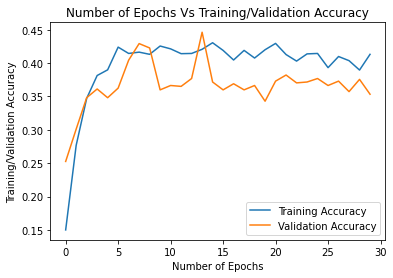

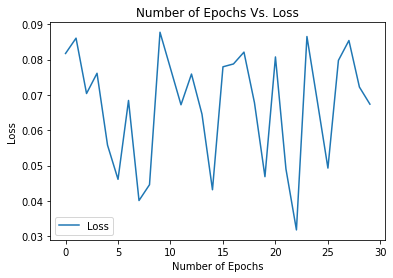

In [ ]:
batch_size = 4 
lr = 0.1
epochs = 30
seed = 0
model = train_full(batch_size,lr,epochs,Net2())

### **Run 3 Paramaters:**
##### *Number of Conv. layers: 2*
##### *Number of kernels on each conv. layer: 10*
##### *Number of Neurons on first layer: 32*
##### *Learning rate: 0.1*
##### *Batch size: 32*
##### *Epochs: 30*

In [89]:
# Model 3
class Net3(nn.Module):
  def __init__(self):
    super(Net3,self).__init__()
    self.conv1 = nn.Conv2d(3,10,3)
    self.pool1 = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(10,10,3)
    self.pool2 = nn.MaxPool2d(2,2,padding = 1)

    self.fc1 = nn.Linear(13*13*10,32)
    self.fc2 = nn.Linear(32,16)
    self.fc3 = nn.Linear(16,10)

  def forward(self,x):
    x = self.pool1(F.relu(self.conv1(x)))
    x = self.pool2(F.relu(self.conv2(x)))
    x = x.view(-1,13*13*10)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = (self.fc3(x))
    return x
summary(Net3(),(3,56,56))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 54, 54]             280
         MaxPool2d-2           [-1, 10, 27, 27]               0
            Conv2d-3           [-1, 10, 25, 25]             910
         MaxPool2d-4           [-1, 10, 13, 13]               0
            Linear-5                   [-1, 32]          54,112
            Linear-6                   [-1, 16]             528
            Linear-7                   [-1, 10]             170
Total params: 56,000
Trainable params: 56,000
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.04
Forward/backward pass size (MB): 0.34
Params size (MB): 0.21
Estimated Total Size (MB): 0.59
----------------------------------------------------------------


Epoch = 1
Training accuracy: 0.212
Validation accuracy: 0.325
Loss: 0.080
Time: 10.73


Epoch = 2
Training accuracy: 0.380
Validation accuracy: 0.457
Loss: 0.079
Time: 21.24


Epoch = 3
Training accuracy: 0.473
Validation accuracy: 0.415
Loss: 0.070
Time: 31.51


Epoch = 4
Training accuracy: 0.525
Validation accuracy: 0.543
Loss: 0.069
Time: 41.71


Epoch = 5
Training accuracy: 0.579
Validation accuracy: 0.567
Loss: 0.071
Time: 52.39


Epoch = 6
Training accuracy: 0.600
Validation accuracy: 0.618
Loss: 0.057
Time: 62.73


Epoch = 7
Training accuracy: 0.632
Validation accuracy: 0.636
Loss: 0.065
Time: 72.86


Epoch = 8
Training accuracy: 0.656
Validation accuracy: 0.635
Loss: 0.057
Time: 83.30


Epoch = 9
Training accuracy: 0.674
Validation accuracy: 0.641
Loss: 0.044
Time: 94.18


Epoch = 10
Training accuracy: 0.692
Validation accuracy: 0.675
Loss: 0.049
Time: 104.92


Epoch = 11
Training accuracy: 0.708
Validation accuracy: 0.688
Loss: 0.052
Time: 116.73


Epoch = 12
Training accuracy

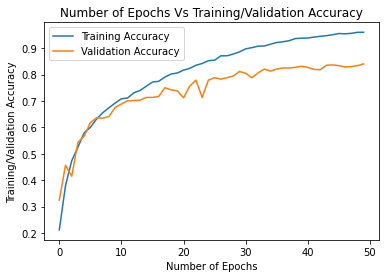

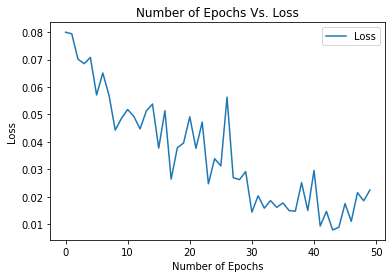

In [92]:
batch_size = 32 
lr = 0.1
epochs = 50
seed = 0
model = train_full(batch_size,lr,epochs,Net3())

### **Run 4 Paramaters:**
##### *Number of Conv. layers: 2*
##### *Number of kernels on each conv. layer: 10*
##### *Number of Neurons on first layer: 32*
##### *Learning rate: 0.01*
##### *Batch size: 4*
##### *Epochs: 30*

In [93]:
# Model 4
class Net4(nn.Module):
  def __init__(self):
    super(Net4,self).__init__()
    self.conv1 = nn.Conv2d(3,10,3)
    self.pool1 = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(10,10,3)
    self.pool2 = nn.MaxPool2d(2,2,padding = 1)
    
    self.fc1 = nn.Linear(1690,64)
    self.fc2 = nn.Linear(64,32)
    self.fc3 = nn.Linear(32,10)

  def forward(self,x):
    x = self.pool1(F.relu(self.conv1(x)))
    x = self.pool2(F.relu(self.conv2(x)))
    x = x.view(-1,1690)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = (self.fc3(x))
    return x
summary(Net4(),(3,56,56))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 54, 54]             280
         MaxPool2d-2           [-1, 10, 27, 27]               0
            Conv2d-3           [-1, 10, 25, 25]             910
         MaxPool2d-4           [-1, 10, 13, 13]               0
            Linear-5                   [-1, 64]         108,224
            Linear-6                   [-1, 32]           2,080
            Linear-7                   [-1, 10]             330
Total params: 111,824
Trainable params: 111,824
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.04
Forward/backward pass size (MB): 0.34
Params size (MB): 0.43
Estimated Total Size (MB): 0.80
----------------------------------------------------------------


Epoch = 1
Training accuracy: 0.274
Validation accuracy: 0.394
Loss: 0.073
Time: 12.86


Epoch = 2
Training accuracy: 0.472
Validation accuracy: 0.469
Loss: 0.077
Time: 25.39


Epoch = 3
Training accuracy: 0.551
Validation accuracy: 0.514
Loss: 0.051
Time: 38.19


Epoch = 4
Training accuracy: 0.587
Validation accuracy: 0.556
Loss: 0.078
Time: 51.21


Epoch = 5
Training accuracy: 0.618
Validation accuracy: 0.524
Loss: 0.061
Time: 63.90


Epoch = 6
Training accuracy: 0.616
Validation accuracy: 0.614
Loss: 0.071
Time: 76.85


Epoch = 7
Training accuracy: 0.657
Validation accuracy: 0.622
Loss: 0.049
Time: 90.61


Epoch = 8
Training accuracy: 0.672
Validation accuracy: 0.644
Loss: 0.050
Time: 103.34


Epoch = 9
Training accuracy: 0.697
Validation accuracy: 0.637
Loss: 0.056
Time: 116.09


Epoch = 10
Training accuracy: 0.713
Validation accuracy: 0.683
Loss: 0.016
Time: 129.03


Epoch = 11
Training accuracy: 0.728
Validation accuracy: 0.660
Loss: 0.064
Time: 142.12


Epoch = 12
Training accura

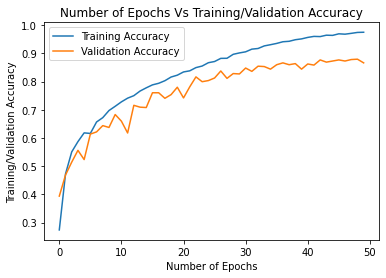

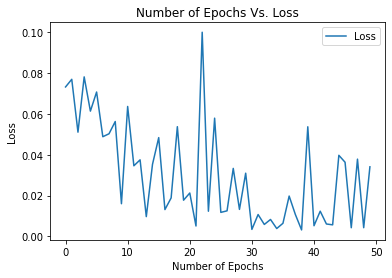

In [95]:
batch_size = 4
lr = 0.01
epochs = 50
seed = 0
model = train_full(batch_size,lr,epochs,Net4())

### **Run 5 Paramaters:**
##### *Number of Conv. layers: 2*
##### *Number of kernels on each conv. layer: 30*
##### *Number of Neurons on first layer: 32*
##### *Learning rate: 0.1*
##### *Batch size: 4*
##### *Epochs: 30*

In [100]:
# Model 5
class Net5(nn.Module):
  def __init__(self):
    super(Net5,self).__init__()
    self.conv1 = nn.Conv2d(3,30,3)
    self.pool1 = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(30,10,3)
    self.pool2 = nn.MaxPool2d(2,2,padding = 1)

    self.fc1 = nn.Linear(13*13*10,32)
    self.fc2 = nn.Linear(32,16)
    self.fc3 = nn.Linear(16,10)

  def forward(self,x):
    x = self.pool1(F.relu(self.conv1(x)))
    x = self.pool2(F.relu(self.conv2(x)))
    x = x.view(-1,13*13*10)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = (self.fc3(x))
    return x
summary(Net5(),(3,56,56))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 30, 54, 54]             840
         MaxPool2d-2           [-1, 30, 27, 27]               0
            Conv2d-3           [-1, 10, 25, 25]           2,710
         MaxPool2d-4           [-1, 10, 13, 13]               0
            Linear-5                   [-1, 32]          54,112
            Linear-6                   [-1, 16]             528
            Linear-7                   [-1, 10]             170
Total params: 58,360
Trainable params: 58,360
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.04
Forward/backward pass size (MB): 0.90
Params size (MB): 0.22
Estimated Total Size (MB): 1.15
----------------------------------------------------------------


Epoch = 1
Training accuracy: 0.357
Validation accuracy: 0.484
Loss: 0.093
Time: 16.86


Epoch = 2
Training accuracy: 0.606
Validation accuracy: 0.607
Loss: 0.061
Time: 33.87


Epoch = 3
Training accuracy: 0.693
Validation accuracy: 0.683
Loss: 0.059
Time: 50.64


Epoch = 4
Training accuracy: 0.740
Validation accuracy: 0.699
Loss: 0.034
Time: 67.47


Epoch = 5
Training accuracy: 0.795
Validation accuracy: 0.776
Loss: 0.050
Time: 84.57


Epoch = 6
Training accuracy: 0.839
Validation accuracy: 0.818
Loss: 0.012
Time: 101.92


Epoch = 7
Training accuracy: 0.861
Validation accuracy: 0.801
Loss: 0.023
Time: 118.92


Epoch = 8
Training accuracy: 0.883
Validation accuracy: 0.796
Loss: 0.035
Time: 135.67


Epoch = 9
Training accuracy: 0.901
Validation accuracy: 0.830
Loss: 0.011
Time: 152.20


Epoch = 10
Training accuracy: 0.924
Validation accuracy: 0.832
Loss: 0.015
Time: 168.80


Epoch = 11
Training accuracy: 0.929
Validation accuracy: 0.829
Loss: 0.022
Time: 185.47


Epoch = 12
Training accu

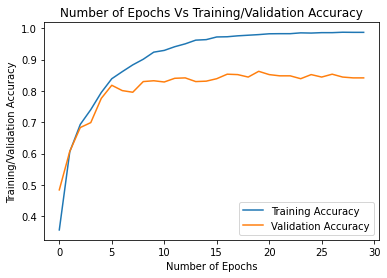

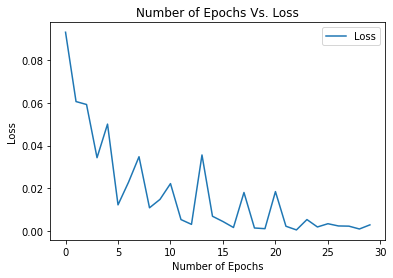

In [101]:
batch_size = 4
lr = 0.1
epochs = 30
seed = 0
model = train_full(batch_size,lr,epochs,Net5())

### **Run 6 Paramaters:**
##### *Number of Conv. layers: 1*
##### *Number of kernels on each conv. layer: 30*
##### *Number of Neurons on first layer: 32*
##### *Learning rate: 0.1*
##### *Batch size: 4*
##### *Epochs: 30*

In [118]:
# Model 6
class Net6(nn.Module):
  def __init__(self):
    super(Net6,self).__init__()
    self.conv1 = nn.Conv2d(3,30,3)
    self.pool1 = nn.MaxPool2d(2,2)

    self.fc1 = nn.Linear(21870,32)
    self.fc2 = nn.Linear(32,16)
    self.fc3 = nn.Linear(16,10)

  def forward(self,x):
    x = self.pool1(F.relu(self.conv1(x)))
    x = x.view(-1,21870)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = (self.fc3(x))
    return x
summary(Net6(),(3,56,56))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 30, 54, 54]             840
         MaxPool2d-2           [-1, 30, 27, 27]               0
            Linear-3                   [-1, 32]         699,872
            Linear-4                   [-1, 16]             528
            Linear-5                   [-1, 10]             170
Total params: 701,410
Trainable params: 701,410
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.04
Forward/backward pass size (MB): 0.83
Params size (MB): 2.68
Estimated Total Size (MB): 3.55
----------------------------------------------------------------


Epoch = 1
Training accuracy: 0.230
Validation accuracy: 0.348
Loss: 0.077
Time: 16.73


Epoch = 2
Training accuracy: 0.455
Validation accuracy: 0.507
Loss: 0.039
Time: 33.50


Epoch = 3
Training accuracy: 0.590
Validation accuracy: 0.565
Loss: 0.071
Time: 50.42


Epoch = 4
Training accuracy: 0.681
Validation accuracy: 0.637
Loss: 0.038
Time: 67.39


Epoch = 5
Training accuracy: 0.765
Validation accuracy: 0.698
Loss: 0.027
Time: 84.54


Epoch = 6
Training accuracy: 0.811
Validation accuracy: 0.716
Loss: 0.047
Time: 101.70


Epoch = 7
Training accuracy: 0.849
Validation accuracy: 0.719
Loss: 0.004
Time: 118.59


Epoch = 8
Training accuracy: 0.884
Validation accuracy: 0.768
Loss: 0.002
Time: 135.35


Epoch = 9
Training accuracy: 0.903
Validation accuracy: 0.760
Loss: 0.028
Time: 151.90


Epoch = 10
Training accuracy: 0.914
Validation accuracy: 0.763
Loss: 0.063
Time: 168.15


Epoch = 11
Training accuracy: 0.931
Validation accuracy: 0.763
Loss: 0.020
Time: 184.52


Epoch = 12
Training accu

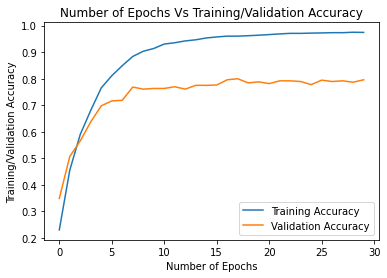

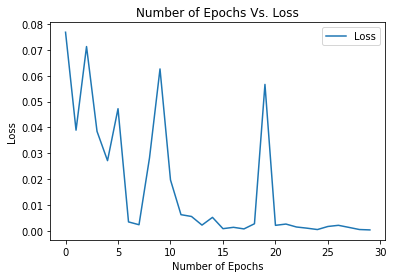

In [119]:
batch_size = 4
lr = 0.1
epochs = 30
seed = 0
model = train_full(batch_size,lr,epochs,Net6())

### **Run 7 Paramaters:**
##### *Number of Conv. layers: 1*
##### *Number of kernels on each conv. layer: 10*
##### *Number of Neurons on first layer: 32*
##### *Learning rate: 0.1*
##### *Batch size: 4*
##### *Epochs: 30*

In [137]:
# Model 7
class Net7(nn.Module):
  def __init__(self):
    super(Net7,self).__init__()
    self.conv1 = nn.Conv2d(3,10,3)
    self.pool1 = nn.MaxPool2d(2,2)

    self.fc1 = nn.Linear(7290,32)
    self.fc2 = nn.Linear(32,16)
    self.fc3 = nn.Linear(16,10)

  def forward(self,x):
    x = self.pool1(F.relu(self.conv1(x)))
    x = x.view(-1,7290)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = (self.fc3(x))
    return x
summary(Net7(),(3,56,56))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 54, 54]             280
         MaxPool2d-2           [-1, 10, 27, 27]               0
            Linear-3                   [-1, 32]         233,312
            Linear-4                   [-1, 16]             528
            Linear-5                   [-1, 10]             170
Total params: 234,290
Trainable params: 234,290
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.04
Forward/backward pass size (MB): 0.28
Params size (MB): 0.89
Estimated Total Size (MB): 1.21
----------------------------------------------------------------


Epoch = 1
Training accuracy: 0.299
Validation accuracy: 0.437
Loss: 0.082
Time: 11.18


Epoch = 2
Training accuracy: 0.520
Validation accuracy: 0.585
Loss: 0.064
Time: 22.34


Epoch = 3
Training accuracy: 0.635
Validation accuracy: 0.671
Loss: 0.018
Time: 33.32


Epoch = 4
Training accuracy: 0.707
Validation accuracy: 0.688
Loss: 0.060
Time: 44.32


Epoch = 5
Training accuracy: 0.774
Validation accuracy: 0.699
Loss: 0.136
Time: 55.15


Epoch = 6
Training accuracy: 0.819
Validation accuracy: 0.695
Loss: 0.012
Time: 65.93


Epoch = 7
Training accuracy: 0.848
Validation accuracy: 0.738
Loss: 0.023
Time: 76.90


Epoch = 8
Training accuracy: 0.869
Validation accuracy: 0.724
Loss: 0.051
Time: 87.80


Epoch = 9
Training accuracy: 0.892
Validation accuracy: 0.720
Loss: 0.005
Time: 98.58


Epoch = 10
Training accuracy: 0.905
Validation accuracy: 0.766
Loss: 0.015
Time: 109.20


Epoch = 11
Training accuracy: 0.925
Validation accuracy: 0.724
Loss: 0.012
Time: 119.99


Epoch = 12
Training accuracy

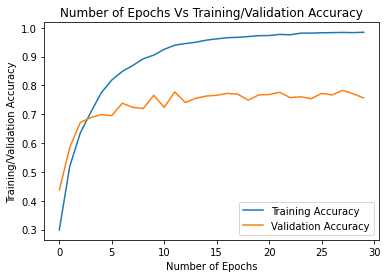

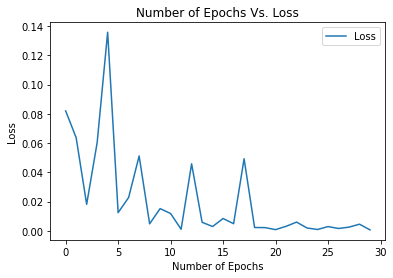

In [138]:
batch_size = 4
lr = 0.1
epochs = 30
seed = 0
model = train_full(batch_size,lr,epochs,Net7())

### **Run 8 Paramaters:**
##### *Number of Conv. layers: 4*
##### *Number of kernels on each conv. layer: 10*
##### *Number of Neurons on first layer: 32*
##### *Learning rate: 0.1*
##### *Batch size: 4*
##### *Epochs: 30*

In [157]:
# Model 8
class Net8(nn.Module):
  def __init__(self):
    super(Net8,self).__init__()
    self.conv1 = nn.Conv2d(3,10,3)
    self.conv2 = nn.Conv2d(10,10,3)
    self.conv3 = nn.Conv2d(10,10,3)
    self.conv4 = nn.Conv2d(10,10,3)
    self.pool1 = nn.MaxPool2d(2,2)
    self.pool2 = nn.MaxPool2d(2,2,1)
    self.fc1 = nn.Linear(40,32)
    self.fc2 = nn.Linear(32,16)
    self.fc3 = nn.Linear(16,10)

  def forward(self,x):
    x = self.pool1(F.relu(self.conv1(x)))
    x = self.pool1(F.relu(self.conv2(x)))
    x = self.pool1(F.relu(self.conv2(x)))
    x = self.pool2(F.relu(self.conv2(x)))
    x = x.view(-1,40)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = (self.fc3(x))
    return x
summary(Net8(),(3,56,56))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 54, 54]             280
         MaxPool2d-2           [-1, 10, 27, 27]               0
            Conv2d-3           [-1, 10, 25, 25]             910
         MaxPool2d-4           [-1, 10, 12, 12]               0
            Conv2d-5           [-1, 10, 10, 10]             910
         MaxPool2d-6             [-1, 10, 5, 5]               0
            Conv2d-7             [-1, 10, 3, 3]             910
         MaxPool2d-8             [-1, 10, 2, 2]               0
            Linear-9                   [-1, 32]           1,312
           Linear-10                   [-1, 16]             528
           Linear-11                   [-1, 10]             170
Total params: 5,020
Trainable params: 5,020
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.04
Forward/back

Epoch = 1
Training accuracy: 0.226
Validation accuracy: 0.298
Loss: 0.078
Time: 13.07


Epoch = 2
Training accuracy: 0.388
Validation accuracy: 0.408
Loss: 0.069
Time: 26.31


Epoch = 3
Training accuracy: 0.513
Validation accuracy: 0.471
Loss: 0.066
Time: 39.45


Epoch = 4
Training accuracy: 0.608
Validation accuracy: 0.628
Loss: 0.046
Time: 52.41


Epoch = 5
Training accuracy: 0.680
Validation accuracy: 0.641
Loss: 0.050
Time: 65.47


Epoch = 6
Training accuracy: 0.729
Validation accuracy: 0.645
Loss: 0.036
Time: 78.66


Epoch = 7
Training accuracy: 0.761
Validation accuracy: 0.700
Loss: 0.023
Time: 91.86


Epoch = 8
Training accuracy: 0.792
Validation accuracy: 0.749
Loss: 0.021
Time: 104.99


Epoch = 9
Training accuracy: 0.792
Validation accuracy: 0.759
Loss: 0.012
Time: 118.09


Epoch = 10
Training accuracy: 0.812
Validation accuracy: 0.760
Loss: 0.013
Time: 131.44


Epoch = 11
Training accuracy: 0.823
Validation accuracy: 0.777
Loss: 0.070
Time: 144.48


Epoch = 12
Training accura

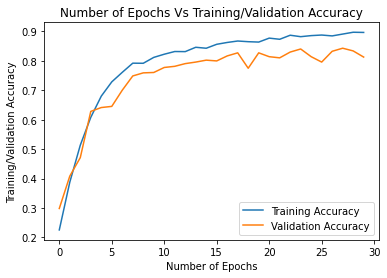

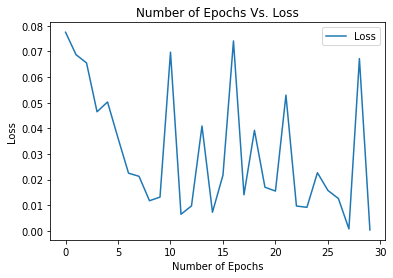

In [144]:
batch_size = 4
lr = 0.1
epochs = 30
seed = 0
model = train_full(batch_size,lr,epochs,Net8())

### **Run 9 Paramaters:**
##### *Number of Conv. layers: 4*
##### *Number of kernels on each conv. layer: 30*
##### *Number of Neurons on first layer: 32*
##### *Learning rate: 0.1*
##### *Batch size: 4*
##### *Epochs: 30*

In [154]:
# Model 9
class Net9(nn.Module):
  def __init__(self):
    super(Net9,self).__init__()
    self.conv1 = nn.Conv2d(3,30,3)
    self.conv2 = nn.Conv2d(30,30,3)
    self.conv3 = nn.Conv2d(30,30,3)
    self.conv4 = nn.Conv2d(30,30,3)
    self.pool1 = nn.MaxPool2d(2,2)
    self.pool2 = nn.MaxPool2d(2,2,1)
    self.fc1 = nn.Linear(120,32)
    self.fc2 = nn.Linear(32,16)
    self.fc3 = nn.Linear(16,10)

  def forward(self,x):
    x = self.pool1(F.relu(self.conv1(x)))
    x = self.pool1(F.relu(self.conv2(x)))
    x = self.pool1(F.relu(self.conv2(x)))
    x = self.pool2(F.relu(self.conv2(x)))
    x = x.view(-1,120)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = (self.fc3(x))
    return x
summary(Net9(),(3,56,56))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 30, 54, 54]             840
         MaxPool2d-2           [-1, 30, 27, 27]               0
            Conv2d-3           [-1, 30, 25, 25]           8,130
         MaxPool2d-4           [-1, 30, 12, 12]               0
            Conv2d-5           [-1, 30, 10, 10]           8,130
         MaxPool2d-6             [-1, 30, 5, 5]               0
            Conv2d-7             [-1, 30, 3, 3]           8,130
         MaxPool2d-8             [-1, 30, 2, 2]               0
            Linear-9                   [-1, 32]           3,872
           Linear-10                   [-1, 16]             528
           Linear-11                   [-1, 10]             170
Total params: 29,800
Trainable params: 29,800
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.04
Forward/ba

Epoch = 1
Training accuracy: 0.160
Validation accuracy: 0.194
Loss: 0.080
Time: 20.16


Epoch = 2
Training accuracy: 0.358
Validation accuracy: 0.346
Loss: 0.090
Time: 39.47


Epoch = 3
Training accuracy: 0.521
Validation accuracy: 0.623
Loss: 0.092
Time: 59.30


Epoch = 4
Training accuracy: 0.626
Validation accuracy: 0.690
Loss: 0.053
Time: 79.54


Epoch = 5
Training accuracy: 0.704
Validation accuracy: 0.694
Loss: 0.034
Time: 98.98


Epoch = 6
Training accuracy: 0.754
Validation accuracy: 0.804
Loss: 0.026
Time: 118.29


Epoch = 7
Training accuracy: 0.793
Validation accuracy: 0.826
Loss: 0.008
Time: 137.78


Epoch = 8
Training accuracy: 0.824
Validation accuracy: 0.863
Loss: 0.003
Time: 156.93


Epoch = 9
Training accuracy: 0.846
Validation accuracy: 0.864
Loss: 0.005
Time: 176.43


Epoch = 10
Training accuracy: 0.868
Validation accuracy: 0.855
Loss: 0.020
Time: 195.78


Epoch = 11
Training accuracy: 0.887
Validation accuracy: 0.881
Loss: 0.005
Time: 215.18


Epoch = 12
Training accu

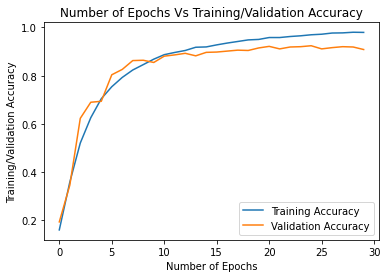

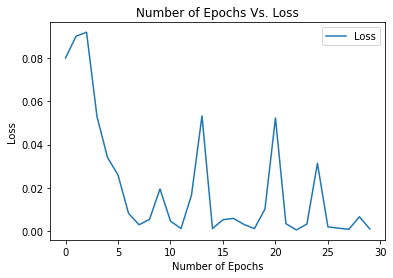

In [155]:
batch_size = 4
lr = 0.1
epochs = 30
seed = 0
model = train_full(batch_size,lr,epochs,Net9())

### **Run 10 Paramaters:**
##### *Number of Conv. layers: 4*
##### *Number of kernels on each conv. layer: 30*
##### *Number of Neurons on first layer: 32*
##### *Learning rate: 0.1*
##### *Batch size: 32*
##### *Epochs: 30*

In [163]:
# Model 10
class Net10(nn.Module):
  def __init__(self):
    super(Net10,self).__init__()
    self.conv1 = nn.Conv2d(3,30,3)
    self.conv2 = nn.Conv2d(30,30,3)
    self.conv3 = nn.Conv2d(30,30,3)
    self.conv4 = nn.Conv2d(30,30,3)
    self.pool1 = nn.MaxPool2d(2,2)
    self.pool2 = nn.MaxPool2d(2,2,1)
    self.fc1 = nn.Linear(120,32)
    self.fc2 = nn.Linear(32,16)
    self.fc3 = nn.Linear(16,10)

  def forward(self,x):
    x = self.pool1(F.relu(self.conv1(x)))
    x = self.pool1(F.relu(self.conv2(x)))
    x = self.pool1(F.relu(self.conv2(x)))
    x = self.pool2(F.relu(self.conv2(x)))
    x = x.view(-1,120)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = (self.fc3(x))
    return x
summary(Net10(),(3,56,56))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 30, 54, 54]             840
         MaxPool2d-2           [-1, 30, 27, 27]               0
            Conv2d-3           [-1, 30, 25, 25]           8,130
         MaxPool2d-4           [-1, 30, 12, 12]               0
            Conv2d-5           [-1, 30, 10, 10]           8,130
         MaxPool2d-6             [-1, 30, 5, 5]               0
            Conv2d-7             [-1, 30, 3, 3]           8,130
         MaxPool2d-8             [-1, 30, 2, 2]               0
            Linear-9                   [-1, 32]           3,872
           Linear-10                   [-1, 16]             528
           Linear-11                   [-1, 10]             170
Total params: 29,800
Trainable params: 29,800
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.04
Forward/ba

Epoch = 1
Training accuracy: 0.110
Validation accuracy: 0.130
Loss: 0.091
Time: 15.98


Epoch = 2
Training accuracy: 0.175
Validation accuracy: 0.225
Loss: 0.091
Time: 31.97


Epoch = 3
Training accuracy: 0.238
Validation accuracy: 0.293
Loss: 0.084
Time: 47.93


Epoch = 4
Training accuracy: 0.290
Validation accuracy: 0.274
Loss: 0.078
Time: 64.08


Epoch = 5
Training accuracy: 0.324
Validation accuracy: 0.272
Loss: 0.085
Time: 80.05


Epoch = 6
Training accuracy: 0.363
Validation accuracy: 0.346
Loss: 0.078
Time: 96.09


Epoch = 7
Training accuracy: 0.429
Validation accuracy: 0.421
Loss: 0.078
Time: 112.40


Epoch = 8
Training accuracy: 0.485
Validation accuracy: 0.546
Loss: 0.078
Time: 128.61


Epoch = 9
Training accuracy: 0.528
Validation accuracy: 0.415
Loss: 0.073
Time: 144.95


Epoch = 10
Training accuracy: 0.560
Validation accuracy: 0.420
Loss: 0.070
Time: 161.41


Epoch = 11
Training accuracy: 0.578
Validation accuracy: 0.552
Loss: 0.068
Time: 177.77


Epoch = 12
Training accur

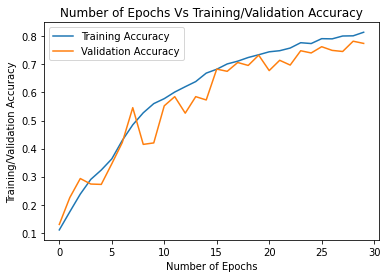

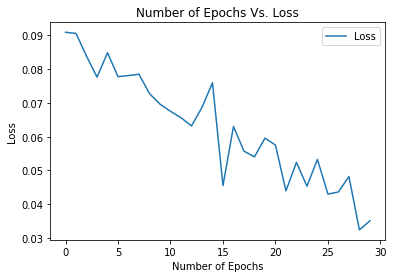

In [159]:
batch_size = 32
lr = 0.1
epochs = 30
seed = 0
model = train_full(batch_size,lr,epochs,Net10())

### **Run 11 Paramaters:**
##### *Number of Conv. layers: 4*
##### *Number of kernels on each conv. layer: 30*
##### *Number of Neurons on first layer: 32*
##### *Learning rate: 0.01*
##### *Batch size: 4*
##### *Epochs: 50*

In [164]:
# Model 11
class Net11(nn.Module):
  def __init__(self):
    super(Net11,self).__init__()
    self.conv1 = nn.Conv2d(3,30,3)
    self.conv2 = nn.Conv2d(30,30,3)
    self.conv3 = nn.Conv2d(30,30,3)
    self.conv4 = nn.Conv2d(30,30,3)
    self.pool1 = nn.MaxPool2d(2,2)
    self.pool2 = nn.MaxPool2d(2,2,1)
    self.fc1 = nn.Linear(120,32)
    self.fc2 = nn.Linear(32,16)
    self.fc3 = nn.Linear(16,10)

  def forward(self,x):
    x = self.pool1(F.relu(self.conv1(x)))
    x = self.pool1(F.relu(self.conv2(x)))
    x = self.pool1(F.relu(self.conv2(x)))
    x = self.pool2(F.relu(self.conv2(x)))
    x = x.view(-1,120)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = (self.fc3(x))
    return x
summary(Net11(),(3,56,56))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 30, 54, 54]             840
         MaxPool2d-2           [-1, 30, 27, 27]               0
            Conv2d-3           [-1, 30, 25, 25]           8,130
         MaxPool2d-4           [-1, 30, 12, 12]               0
            Conv2d-5           [-1, 30, 10, 10]           8,130
         MaxPool2d-6             [-1, 30, 5, 5]               0
            Conv2d-7             [-1, 30, 3, 3]           8,130
         MaxPool2d-8             [-1, 30, 2, 2]               0
            Linear-9                   [-1, 32]           3,872
           Linear-10                   [-1, 16]             528
           Linear-11                   [-1, 10]             170
Total params: 29,800
Trainable params: 29,800
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.04
Forward/ba

Epoch = 1
Training accuracy: 0.096
Validation accuracy: 0.075
Loss: 0.089
Time: 20.38


Epoch = 2
Training accuracy: 0.092
Validation accuracy: 0.102
Loss: 0.088
Time: 39.54


Epoch = 3
Training accuracy: 0.107
Validation accuracy: 0.092
Loss: 0.090
Time: 58.56


Epoch = 4
Training accuracy: 0.112
Validation accuracy: 0.102
Loss: 0.089
Time: 77.83


Epoch = 5
Training accuracy: 0.118
Validation accuracy: 0.114
Loss: 0.090
Time: 97.00


Epoch = 6
Training accuracy: 0.137
Validation accuracy: 0.105
Loss: 0.090
Time: 116.07


Epoch = 7
Training accuracy: 0.127
Validation accuracy: 0.160
Loss: 0.089
Time: 135.14


Epoch = 8
Training accuracy: 0.159
Validation accuracy: 0.156
Loss: 0.088
Time: 154.16


Epoch = 9
Training accuracy: 0.163
Validation accuracy: 0.124
Loss: 0.089
Time: 173.05


Epoch = 10
Training accuracy: 0.146
Validation accuracy: 0.141
Loss: 0.088
Time: 192.25


Epoch = 11
Training accuracy: 0.200
Validation accuracy: 0.174
Loss: 0.088
Time: 211.25


Epoch = 12
Training accu

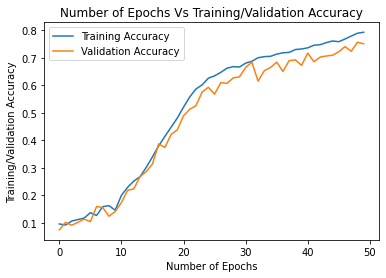

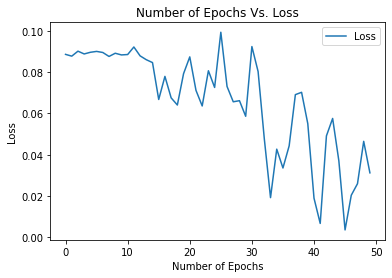

In [165]:
batch_size = 4
lr = 0.01
epochs = 50
seed = 0
model = train_full(batch_size,lr,epochs,Net11())

### **Run 12 Paramaters:**
##### *Number of Conv. layers: 4*
##### *Number of kernels on each conv. layer: 30*
##### *Number of Neurons on first layer: 8*
##### *Learning rate: 0.1*
##### *Batch size: 4*
##### *Epochs: 40*

In [161]:
# Model 12
class Net12(nn.Module):
  def __init__(self):
    super(Net12,self).__init__()
    self.conv1 = nn.Conv2d(3,30,3)
    self.conv2 = nn.Conv2d(30,30,3)
    self.conv3 = nn.Conv2d(30,30,3)
    self.conv4 = nn.Conv2d(30,30,3)
    self.pool1 = nn.MaxPool2d(2,2)
    self.pool2 = nn.MaxPool2d(2,2,1)
    self.fc1 = nn.Linear(120,8)
    self.fc2 = nn.Linear(8,4)
    self.fc3 = nn.Linear(4,10)

  def forward(self,x):
    x = self.pool1(F.relu(self.conv1(x)))
    x = self.pool1(F.relu(self.conv2(x)))
    x = self.pool1(F.relu(self.conv2(x)))
    x = self.pool2(F.relu(self.conv2(x)))
    x = x.view(-1,120)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = (self.fc3(x))
    return x
summary(Net12(),(3,56,56))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 30, 54, 54]             840
         MaxPool2d-2           [-1, 30, 27, 27]               0
            Conv2d-3           [-1, 30, 25, 25]           8,130
         MaxPool2d-4           [-1, 30, 12, 12]               0
            Conv2d-5           [-1, 30, 10, 10]           8,130
         MaxPool2d-6             [-1, 30, 5, 5]               0
            Conv2d-7             [-1, 30, 3, 3]           8,130
         MaxPool2d-8             [-1, 30, 2, 2]               0
            Linear-9                    [-1, 8]             968
           Linear-10                    [-1, 4]              36
           Linear-11                   [-1, 10]              50
Total params: 26,284
Trainable params: 26,284
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.04
Forward/ba

Epoch = 1
Training accuracy: 0.120
Validation accuracy: 0.120
Loss: 0.090
Time: 19.28


Epoch = 2
Training accuracy: 0.247
Validation accuracy: 0.323
Loss: 0.078
Time: 38.52


Epoch = 3
Training accuracy: 0.294
Validation accuracy: 0.347
Loss: 0.097
Time: 57.84


Epoch = 4
Training accuracy: 0.308
Validation accuracy: 0.302
Loss: 0.077
Time: 77.25


Epoch = 5
Training accuracy: 0.307
Validation accuracy: 0.376
Loss: 0.085
Time: 96.87


Epoch = 6
Training accuracy: 0.355
Validation accuracy: 0.332
Loss: 0.081
Time: 116.71


Epoch = 7
Training accuracy: 0.394
Validation accuracy: 0.428
Loss: 0.076
Time: 136.14


Epoch = 8
Training accuracy: 0.424
Validation accuracy: 0.423
Loss: 0.092
Time: 155.54


Epoch = 9
Training accuracy: 0.450
Validation accuracy: 0.450
Loss: 0.068
Time: 175.00


Epoch = 10
Training accuracy: 0.472
Validation accuracy: 0.499
Loss: 0.066
Time: 194.84


Epoch = 11
Training accuracy: 0.480
Validation accuracy: 0.453
Loss: 0.080
Time: 214.93


Epoch = 12
Training accu

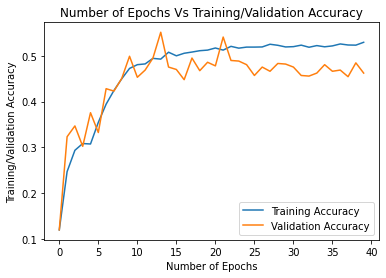

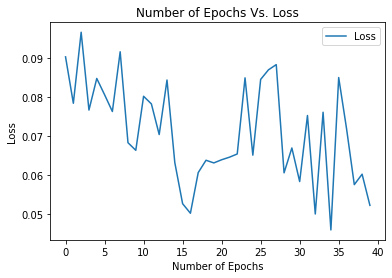

In [162]:
batch_size = 4
lr = 0.1
epochs = 40
seed = 0
model = train_full(batch_size,lr,epochs,Net12())

# 5. Batch Normalization and Cross Entropy Loss Function

## 1. Batch Normalization

In [172]:
class Net_Best1(nn.Module):
  def __init__(self):
    super(Net_Best1,self).__init__()
    self.conv1 = nn.Conv2d(3,30,3)
    self.bn = nn.BatchNorm2d(30)
    self.conv2 = nn.Conv2d(30,30,3)
    self.conv3 = nn.Conv2d(30,30,3)
    self.conv4 = nn.Conv2d(30,30,3)
    self.pool1 = nn.MaxPool2d(2,2)
    self.pool2 = nn.MaxPool2d(2,2,1)

    self.bn_fc1 = nn.BatchNorm1d(32)
    self.fc1 = nn.Linear(120,32)
    self.bn_fc2 = nn.BatchNorm1d(16)
    self.fc2 = nn.Linear(32,16)
    self.fc3 = nn.Linear(16,10)

  def forward(self,x):
    x = self.pool1(F.relu(self.bn(self.conv1(x))))
    x = self.pool1(F.relu(self.bn(self.conv2(x))))
    x = self.pool1(F.relu(self.bn(self.conv2(x))))
    x = self.pool2(F.relu(self.bn(self.conv2(x))))
    x = x.view(-1,120)
    x = F.relu(self.bn_fc1(self.fc1(x)))
    x = self.bn_fc2(self.fc2(x))
    x = self.fc3(x)
    return x
    
summary(Net_Best1(),(3,56,56))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 30, 54, 54]             840
       BatchNorm2d-2           [-1, 30, 54, 54]              60
         MaxPool2d-3           [-1, 30, 27, 27]               0
            Conv2d-4           [-1, 30, 25, 25]           8,130
       BatchNorm2d-5           [-1, 30, 25, 25]              60
         MaxPool2d-6           [-1, 30, 12, 12]               0
            Conv2d-7           [-1, 30, 10, 10]           8,130
       BatchNorm2d-8           [-1, 30, 10, 10]              60
         MaxPool2d-9             [-1, 30, 5, 5]               0
           Conv2d-10             [-1, 30, 3, 3]           8,130
      BatchNorm2d-11             [-1, 30, 3, 3]              60
        MaxPool2d-12             [-1, 30, 2, 2]               0
           Linear-13                   [-1, 32]           3,872
      BatchNorm1d-14                   

Epoch = 1
Training accuracy: 0.190
Validation accuracy: 0.195
Loss: 0.080
Time: 30.78


Epoch = 2
Training accuracy: 0.264
Validation accuracy: 0.315
Loss: 0.104
Time: 60.05


Epoch = 3
Training accuracy: 0.332
Validation accuracy: 0.352
Loss: 0.114
Time: 88.55


Epoch = 4
Training accuracy: 0.384
Validation accuracy: 0.403
Loss: 0.100
Time: 117.39


Epoch = 5
Training accuracy: 0.478
Validation accuracy: 0.479
Loss: 0.099
Time: 145.47


Epoch = 6
Training accuracy: 0.528
Validation accuracy: 0.513
Loss: 0.107
Time: 171.82


Epoch = 7
Training accuracy: 0.573
Validation accuracy: 0.550
Loss: 0.077
Time: 197.39


Epoch = 8
Training accuracy: 0.609
Validation accuracy: 0.616
Loss: 0.071
Time: 222.52


Epoch = 9
Training accuracy: 0.682
Validation accuracy: 0.645
Loss: 0.070
Time: 247.58


Epoch = 10
Training accuracy: 0.688
Validation accuracy: 0.664
Loss: 0.059
Time: 272.82


Epoch = 11
Training accuracy: 0.713
Validation accuracy: 0.668
Loss: 0.139
Time: 298.29


Epoch = 12
Training ac

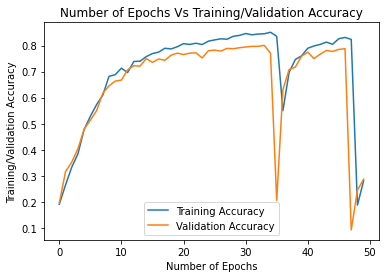

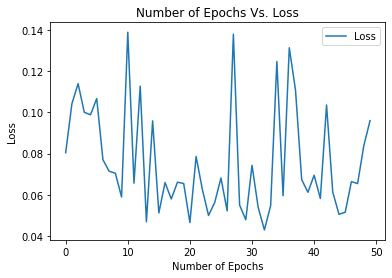

In [173]:
batch_size = 4
lr = 0.1
epochs = 50
seed = 0
model = train_full(batch_size,lr,epochs,Net_Best1())

## 2. Cross Entropy Loss

In [176]:
class Net_Best2(nn.Module):
  def __init__(self):
    super(Net_Best2,self).__init__()
    self.conv1 = nn.Conv2d(3,30,3)
    self.conv2 = nn.Conv2d(30,30,3)
    self.conv3 = nn.Conv2d(30,30,3)
    self.conv4 = nn.Conv2d(30,30,3)
    self.pool1 = nn.MaxPool2d(2,2)
    self.pool2 = nn.MaxPool2d(2,2,1)
    self.fc1 = nn.Linear(120,32)
    self.fc2 = nn.Linear(32,16)
    self.fc3 = nn.Linear(16,10)

  def forward(self,x):
    x = self.pool1(F.relu(self.conv1(x)))
    x = self.pool1(F.relu(self.conv2(x)))
    x = self.pool1(F.relu(self.conv2(x)))
    x = self.pool2(F.relu(self.conv2(x)))
    x = x.view(-1,120)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x
    
summary(Net_Best2(),(3,56,56))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 30, 54, 54]             840
         MaxPool2d-2           [-1, 30, 27, 27]               0
            Conv2d-3           [-1, 30, 25, 25]           8,130
         MaxPool2d-4           [-1, 30, 12, 12]               0
            Conv2d-5           [-1, 30, 10, 10]           8,130
         MaxPool2d-6             [-1, 30, 5, 5]               0
            Conv2d-7             [-1, 30, 3, 3]           8,130
         MaxPool2d-8             [-1, 30, 2, 2]               0
            Linear-9                   [-1, 32]           3,872
           Linear-10                   [-1, 16]             528
           Linear-11                   [-1, 10]             170
Total params: 29,800
Trainable params: 29,800
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.04
Forward/ba

In [186]:
def evaluate_ce(model,val_loader):
  total = 0 
  correct = 0
  for idx,(inputs,labels) in enumerate(val_loader,0):
    predict = model(inputs.float())
    _, predicted = torch.max(predict.data,1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
  val_acc = correct / total

  return val_acc

def train_full_ce(batch_size,lr,epochs,model):
 
  train_loader,val_loader = get_split_data(batch_size,new_mean,new_std,new_path,0.2)
  loss_fcn = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(),lr=lr)

  trainAccRec = []
  valAccRec = []
  loss_rec = []
  t = []
  tic = time.time()


  model.train()
  for epoch in range (1,epochs+1):
    correct = 0
    total = 0
    for i,(inputs,labels) in enumerate(train_loader,0):
      
      #labels_H = torch.tensor([TenToOneH(float(i)) for i in labels])
      optimizer.zero_grad()   
      predict = model(inputs.float())

      
      
      loss = loss_fcn(input = predict.squeeze(),target=labels)
      loss.backward()
      optimizer.step()
      

      _, predicted = torch.max(predict.data,1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      
  
    train_acc = correct / total
    val_acc = evaluate(model,val_loader)

    valAccRec.append(val_acc)
    trainAccRec.append(train_acc)

    t.append(time.time()-tic)
    loss_rec.append(loss.item())  

    print("Epoch = %d"%epoch)
    print("Training accuracy: %.3f"%train_acc)
    print("Validation accuracy: %.3f"%val_acc)
    print("Loss: %.3f"%loss.item())
    print("Time: %.2f"%(time.time()-tic))
    print("\n")

  toc = time.time()
  print("Total time:%.3f"%(toc-tic))
  num_epochs = list(range(epochs)) 

  plt.plot(num_epochs,trainAccRec,label="Training Accuracy")
  plt.plot(num_epochs,valAccRec,label="Validation Accuracy")
  plt.legend()
  plt.xlabel("Number of Epochs")
  plt.ylabel("Training/Validation Accuracy")
  plt.title("Number of Epochs Vs Training/Validation Accuracy")
  plt.show()

  plt.plot(num_epochs,loss_rec,label="Loss")
  plt.xlabel("Number of Epochs")
  plt.ylabel("Loss")
  plt.title("Number of Epochs Vs. Loss")
  plt.legend()
  plt.show()
  
  return model

In [187]:
batch_size = 4
lr = 0.1
epochs = 30
seed = 0
model = train_full_ce(batch_size,lr,epochs,Net_Best2())

Epoch = 1
Training accuracy: 0.135
Validation accuracy: 0.240
Loss: 2.302
Time: 30.68


Epoch = 2
Training accuracy: 0.209
Validation accuracy: 0.140
Loss: 2.156
Time: 59.77


Epoch = 3
Training accuracy: 0.165
Validation accuracy: 0.098
Loss: 2.289
Time: 87.32


Epoch = 4
Training accuracy: 0.093
Validation accuracy: 0.096
Loss: 2.268
Time: 116.00


Epoch = 5
Training accuracy: 0.107
Validation accuracy: 0.105
Loss: 2.278
Time: 142.02


Epoch = 6
Training accuracy: 0.103
Validation accuracy: 0.109
Loss: 2.195
Time: 163.29


Epoch = 7
Training accuracy: 0.109
Validation accuracy: 0.099
Loss: 2.137
Time: 183.37


Epoch = 8
Training accuracy: 0.098
Validation accuracy: 0.113
Loss: 2.320
Time: 202.00


Epoch = 9
Training accuracy: 0.098
Validation accuracy: 0.109
Loss: 2.445
Time: 220.70


Epoch = 10
Training accuracy: 0.095
Validation accuracy: 0.096
Loss: 2.332
Time: 239.49


Epoch = 11
Training accuracy: 0.107
Validation accuracy: 0.096
Loss: 2.325
Time: 258.26


Epoch = 12
Training ac

KeyboardInterrupt: ignored

## 3. Batch Noramlization and Cross Entropy Loss

# 6. Final Best Networks and Confusion Matrix

## Part 1

Epoch = 1
Training accuracy: 0.203
Validation accuracy: 0.245
Loss: 0.085
Time: 29.76


Epoch = 2
Training accuracy: 0.416
Validation accuracy: 0.463
Loss: 0.092
Time: 60.89


Epoch = 3
Training accuracy: 0.551
Validation accuracy: 0.594
Loss: 0.025
Time: 88.85


Epoch = 4
Training accuracy: 0.642
Validation accuracy: 0.669
Loss: 0.075
Time: 119.58


Epoch = 5
Training accuracy: 0.711
Validation accuracy: 0.725
Loss: 0.019
Time: 153.30


Epoch = 6
Training accuracy: 0.765
Validation accuracy: 0.707
Loss: 0.054
Time: 187.09


Epoch = 7
Training accuracy: 0.806
Validation accuracy: 0.798
Loss: 0.050
Time: 215.76


Epoch = 8
Training accuracy: 0.832
Validation accuracy: 0.747
Loss: 0.034
Time: 247.01


Epoch = 9
Training accuracy: 0.847
Validation accuracy: 0.818
Loss: 0.008
Time: 277.25


Epoch = 10
Training accuracy: 0.864
Validation accuracy: 0.830
Loss: 0.009
Time: 306.85


Epoch = 11
Training accuracy: 0.878
Validation accuracy: 0.835
Loss: 0.008
Time: 338.77


Epoch = 12
Training ac

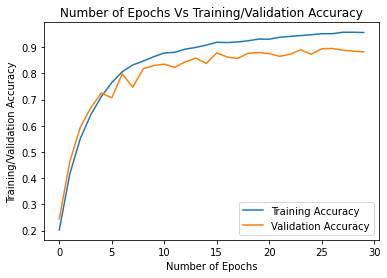

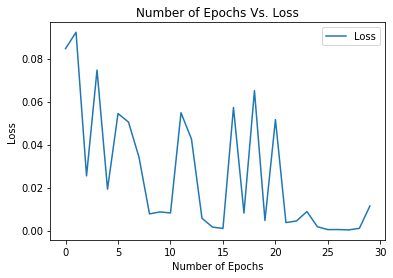

In [191]:
batch_size = 4
lr = 0.1
epochs = 30
seed = 0
model = train_full(batch_size,lr,epochs,Net9())
torch.save(model.state_dict(),"MyBest.pt")

## Part 2

In [192]:
# Model small
class Net_small(nn.Module):
  def __init__(self):
    super(Net_small,self).__init__()
    self.conv1 = nn.Conv2d(3,10,3)
    self.conv2 = nn.Conv2d(10,10,3)
    self.conv3 = nn.Conv2d(10,10,3)
    self.conv4 = nn.Conv2d(10,10,3)
    self.pool1 = nn.MaxPool2d(2,2)
    self.pool2 = nn.MaxPool2d(2,2,1)
    self.fc1 = nn.Linear(40,30)
    self.fc2 = nn.Linear(30,16)
    self.fc3 = nn.Linear(16,10)

  def forward(self,x):
    x = self.pool1(F.relu(self.conv1(x)))
    x = self.pool1(F.relu(self.conv2(x)))
    x = self.pool1(F.relu(self.conv2(x)))
    x = self.pool2(F.relu(self.conv2(x)))
    x = x.view(-1,40)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = (self.fc3(x))
    return x
summary(Net_small(),(3,56,56))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 54, 54]             280
         MaxPool2d-2           [-1, 10, 27, 27]               0
            Conv2d-3           [-1, 10, 25, 25]             910
         MaxPool2d-4           [-1, 10, 12, 12]               0
            Conv2d-5           [-1, 10, 10, 10]             910
         MaxPool2d-6             [-1, 10, 5, 5]               0
            Conv2d-7             [-1, 10, 3, 3]             910
         MaxPool2d-8             [-1, 10, 2, 2]               0
            Linear-9                   [-1, 30]           1,230
           Linear-10                   [-1, 16]             496
           Linear-11                   [-1, 10]             170
Total params: 4,906
Trainable params: 4,906
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.04
Forward/back

Epoch = 1
Training accuracy: 0.110
Validation accuracy: 0.098
Loss: 0.092
Time: 24.12


Epoch = 2
Training accuracy: 0.093
Validation accuracy: 0.103
Loss: 0.091
Time: 44.09


Epoch = 3
Training accuracy: 0.107
Validation accuracy: 0.116
Loss: 0.087
Time: 66.20


Epoch = 4
Training accuracy: 0.175
Validation accuracy: 0.151
Loss: 0.103
Time: 87.26


Epoch = 5
Training accuracy: 0.360
Validation accuracy: 0.432
Loss: 0.066
Time: 105.30


Epoch = 6
Training accuracy: 0.479
Validation accuracy: 0.495
Loss: 0.072
Time: 119.09


Epoch = 7
Training accuracy: 0.544
Validation accuracy: 0.555
Loss: 0.064
Time: 132.94


Epoch = 8
Training accuracy: 0.609
Validation accuracy: 0.567
Loss: 0.055
Time: 152.97


Epoch = 9
Training accuracy: 0.668
Validation accuracy: 0.664
Loss: 0.017
Time: 173.58


Epoch = 10
Training accuracy: 0.708
Validation accuracy: 0.700
Loss: 0.010
Time: 194.64


Epoch = 11
Training accuracy: 0.737
Validation accuracy: 0.740
Loss: 0.068
Time: 212.09


Epoch = 12
Training acc

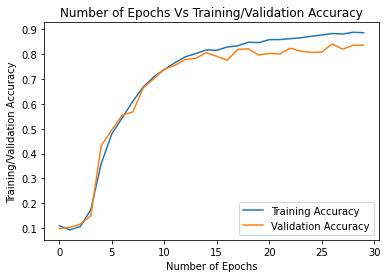

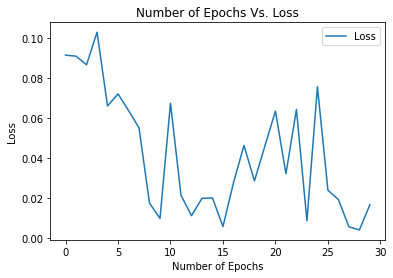

In [193]:
batch_size = 4
lr = 0.1
epochs = 30
seed = 0
model = train_full(batch_size,lr,epochs,Net_small())
torch.save(model.state_dict(),"MyBestSmall.pt")